### Import

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import hauer

In [2]:
pd.set_option('display.max_colwidth', 500)
pd.set_option('display.max_rows', 500)

### Naïve BA Examples

In [23]:
# Numerical Example 7.2. Differing ratios of duration (pg 78)
# Dataset
df = pd.DataFrame()
df['treatment_before_duration'] = [3,3,2,2,1]
df['treatment_after_duration'] = [1,1,1,1,1]
df['treatment_before_count'] = [31,23,7,8,5]
df['treatment_after_count'] = [7,4,1,5,7]

# Run
df_modified, result = hauer.NaiveBeforeAfter(df)

result

C:\Users\thiag\OneDrive\Documents\Repositórios (Local)\hauer-before-after\hauer.py:240: RuntimeWarning: invalid value encountered in scalar power
  std_teta_vte = var_teta_vte**0.5


,NAive BA
lambda,24.000000
var_lambda,24.000000
std_lambda,4.898979
pi,30.500000
var_pi,14.750000
std_pi,3.840573
delta,6.500000
delta_norm,1.300000
var_delta,38.750000
std_delta,6.224950


### Comparison Group BA Examples

In [25]:
# Numerical Example 9.3. R.I.D.E. with comparison groups.
df_t= pd.DataFrame()
df_t['treatment_before_duration'] = [1]
df_t['treatment_after_duration'] = [1]
df_t['treatment_before_count'] = [173]
df_t['treatment_after_count'] = [144]

df_cg = pd.DataFrame()
df_cg['comparison_group_before_duration'] = [1]
df_cg['comparison_group_after_duration'] = [1]
df_cg['comparison_group_before_count'] = [897]
df_cg['comparison_group_after_count'] = [870]

df_t_modified, df_cg_modified, result = hauer.ComparisonGroupBeforeAfter(df_t,df_cg,var_w_par=0.0055)

result

,CG BA
K,173.000000
L,144.000000
M,897.000000
N,870.000000
rt,0.968820
var_rt/rt2,0.007764
var_w,0.005500
lambda,144.000000
var_lambda,144.000000
std_lambda,12.000000


### EB Examples

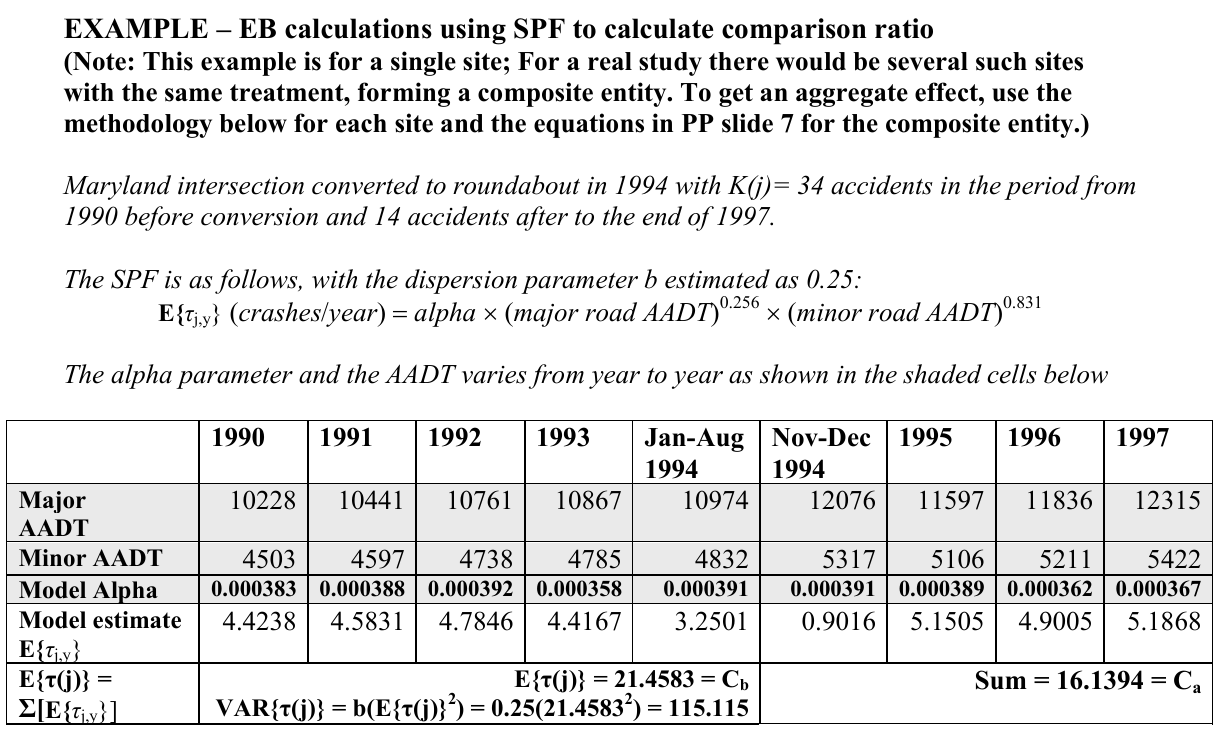

In [8]:
df = pd.DataFrame()
df["entity"] = ["unique"]
df["treatment_before_duration"] = [56]
df["treatment_after_duration"] = [38]
df['treatment_before_count'] = [34]
df['treatment_after_count'] = [14]

# SPF
df_SPF = pd.DataFrame()
# Duration
df_SPF["reference"] = ["1990","1991","1992","1993","Jan-Aug 1994","Nov-Dec 1994","1995","1996","1997"]
df_SPF["period"] = ["before","before","before","before","before","after","after","after","after"]
df_SPF["duration"] = [1,1,1,1,8/12,2/12,1,1,1]
df_SPF.insert(0,"entity","unique")

# Function
SPF = lambda alpha,major_AADT,minor_AADT,duration=1:[duration*alpha*(major_AADT**0.256)*(minor_AADT**0.831),0.25]
df_SPF["alpha"]= [0.000383, 0.000388, 0.000392, 0.000358, 0.000391, 0.000391, 0.000389, 0.000362, 0.000367]
df_SPF["major_AADT"] = [10228, 10441, 10761, 10867, 10974, 12076, 11597, 11836, 12315]
df_SPF["minor_AADT"] = [4503, 4597, 4738, 4785, 4832, 5317, 5106, 5211, 5422]

# Inc Estimated
df_SPF[["tau_par","b"]] = df_SPF.apply(lambda row: SPF(row["alpha"],row["major_AADT"],row["minor_AADT"],row["duration"]),axis=1,result_type="expand")
df_SPF_agg = df_SPF.groupby(["entity","period"]).agg({"tau_par":"sum","b":"mean"}).reset_index(drop=False)
df_SPF_agg["var_tau_par"] = df_SPF_agg["b"]*(df_SPF_agg["tau_par"]**2)

df_SPF_agg_before = df_SPF_agg[df_SPF_agg["period"]=="before"][["entity","tau_par","b","var_tau_par"]]
df_SPF_agg_before.columns = ["entity","tau_par_before","b","var_tau_par_before"]
df_SPF_agg_after = df_SPF_agg[df_SPF_agg["period"]=="after"][["entity","tau_par","var_tau_par"]]
df_SPF_agg_after.columns = ["entity","tau_par_after","var_tau_par_after"]

df = df.merge(df_SPF_agg_before,on="entity",how="left")
df = df.merge(df_SPF_agg_after,on="entity",how="left")

E_k_K = lambda alpha_weight,k,K:(alpha_weight*k) + ((1-alpha_weight)*K)
df["alpha_weight"] = 1/(1+(df["var_tau_par_before"]/df["tau_par_before"]))
df["E_k_K_par"] = df.apply(lambda row:E_k_K(row["alpha_weight"],row["tau_par_before"],row["treatment_before_count"]),axis=1)

df.T

,0
entity,unique
treatment_before_duration,56
treatment_after_duration,38
treatment_before_count,34
treatment_after_count,14
tau_par_before,21.458358
b,0.25
var_tau_par_before,115.115287
tau_par_after,16.138997
var_tau_par_after,65.116803


### Network Screening Examples

In [14]:
df = pd.read_excel("ATV3/SIAT_Cruzamentos_semaforizados_2017_padrão_enunciado.xlsx",sheet_name="Dados Brutos")
df["dummy1"] = 12
df["dummy2"] = 12
df["dummy3"] = 1

df["dummy1@2017"] = 1
df["dummy2@2017"] = 1
df["VMD@2017"] = df["VMD"]
df["Faixas@2017"] = df["Faixas"]

# Crash Rate
Crash_Rate = lambda crash,AATD:crash/(365*AATD/1000000)
df["CR (T)"] = df.apply(lambda row:Crash_Rate(row["Total Sinistros"],row["VMD"]),axis=1)
df = df.sort_values(by="CR (T)",ascending=False)
df["CR_ranking (T)"] = list(range(1,len(df)+1))
df = df.sort_values(by="ID")

df["CR (FF)"] = df.apply(lambda row:Crash_Rate(row["Feridos e Fatais"],row["VMD"]),axis=1)
df = df.sort_values(by="CR (FF)",ascending=False)
df["CR_ranking (FF)"] = list(range(1,len(df)+1))
df = df.sort_values(by="ID")

# Expected Average Crash Frequency with Empirical Bayes (EB) Adjustment
E_k = lambda pars:np.exp(-6.19)*(pars[1]**0.65)*np.exp(0.102*pars[2])
b = 1.978

df,_ = hauer.EmpiricalBayesMethod(
        df,
        E_k,
        b,
        ["VMD","Faixas"],
        2017,
        2017,
        before_duration="dummy1",
        after_duration="dummy2",
        before_count="Total Sinistros",
        after_count="dummy3",
        sep="@")

df[["accident_func_SPF@2017 (T)","alpha (T)"]] = df[["accident_func_SPF@2017","alpha",]]
df["EACF_EB_Adj (T)"] = df["k_par"]
df = df.sort_values(by="EACF_EB_Adj (T)",ascending=False)
df["EACF_EB_Adj_ranking (T)"] = list(range(1,len(df)+1))
df = df.sort_values(by="ID")

#-------------------------------------------------------------------------------------
E_k = lambda pars:np.exp(-11.19)*(pars[1]**0.98)*np.exp(0.095*pars[2])
b = 1.978

df,_ = hauer.EmpiricalBayesMethod(
        df,
        E_k,
        b,
        ["VMD","Faixas"],
        2017,
        2017,
        before_duration="dummy1",
        after_duration="dummy2",
        before_count="Feridos e Fatais",
        after_count="dummy3",
        sep="@")

df[["accident_func_SPF@2017 (FF)","alpha (FF)"]] = df[["accident_func_SPF@2017","alpha",]]
df["EACF_EB_Adj (FF)"] = df["k_par"]
df = df.sort_values(by="EACF_EB_Adj (FF)",ascending=False)
df["EACF_EB_Adj_ranking (FF)"] = list(range(1,len(df)+1))
df = df.sort_values(by="ID")

df = df.drop(columns=['dummy1', 'dummy2',
       'dummy3', 'dummy1@2017', 'dummy2@2017',
       'VMD@2017', 'Faixas@2017','accident_before_SPF@2017',
       'accident_after_SPF@2017', 'Ekb SPF', 'Eka SPF', 'VAR_Ek SPF',
        "accident_func_SPF@2017",	"alpha",
        'k_par', 'var_k_par', 'rC', 'pi_par', 'var_pi_par', 'lambda_par',
       'var_lambda_par', 'teta_par', 'var_teta_par', 'std_teta_par'])

# Excess Expected Average Crash Frequency with Empirical Bayes (EB) Adjustment
df["EEACF_EB_Adj (T)"] = df["EACF_EB_Adj (T)"] - df["accident_func_SPF@2017 (T)"]
df = df.sort_values(by="EEACF_EB_Adj (T)",ascending=False)
df["EEACF_EB_Adj_ranking (T)"] = list(range(1,len(df)+1))
df = df.sort_values(by="ID")

df["EEACF_EB_Adj (FF)"] = df["EACF_EB_Adj (FF)"] - df["accident_func_SPF@2017 (FF)"]
df = df.sort_values(by="EEACF_EB_Adj (FF)",ascending=False)
df["EEACF_EB_Adj_ranking (FF)"] = list(range(1,len(df)+1))
df = df.sort_values(by="ID")

df

C:\Users\thiag\OneDrive\Documents\Repositórios (Local)\hauer-before-after\hauer.py:240: RuntimeWarning: invalid value encountered in sqrt
  std_teta_vte = np.sqrt(var_teta_vte)
C:\Users\thiag\OneDrive\Documents\Repositórios (Local)\hauer-before-after\hauer.py:240: RuntimeWarning: invalid value encountered in sqrt
  std_teta_vte = np.sqrt(var_teta_vte)


,ID CTAFOR,Local,ID,Faixas,VMD,MVE,Total Sinistros,Fatais,Feridos,Feridos e Fatais,...,EACF_EB_Adj (T),EACF_EB_Adj_ranking (T),accident_func_SPF@2017 (FF),alpha (FF),EACF_EB_Adj (FF),EACF_EB_Adj_ranking (FF),EEACF_EB_Adj (T),EEACF_EB_Adj_ranking (T),EEACF_EB_Adj (FF),EEACF_EB_Adj_ranking (FF)
0,3,AV FRANCISCO SA X AV DR THEBERGE,1,8,35229,12.858585,16,1,8,9,...,12.207023,6,0.843861,0.700956,3.282906,9,8.023071,5,2.439045,6
1,6,AV JOSE JATAHY X AV BEZERRA DE MENEZES,2,12,54399,19.855635,19,0,10,10,...,16.958395,2,1.888946,0.511515,5.851076,1,8.613369,4,3.962130,1
2,8,AV DOS EXPEDICIONARIOS X RUA BERNARDO MANUEL X AV PRS COSTA E SILVA,3,12,68741,25.090465,16,1,7,8,...,14.937062,5,2.375812,0.454315,5.444849,2,5.221143,8,3.069038,5
3,9,AV GODOFREDO MACIEL X RUA NEREU RAMOS,4,8,62241,22.717965,18,0,10,10,...,15.059902,4,1.474021,0.572998,5.114633,3,9.002990,2,3.640613,2
4,10,AV JOSE JATAHY X AV JOVITA FEITOSA X AV 13 DE MAIO,5,6,50814,18.547110,14,0,11,11,...,10.967038,7,0.999209,0.664381,4.355668,4,6.637969,6,3.356459,3
5,12,AV JOAO PESSOA X RUA PRO COSTA MENDES,6,6,27600,10.074000,9,2,4,6,...,6.536831,18,0.549393,0.782624,1.734222,18,3.625469,12,1.184828,16
6,14,AV JOSE JATAHY X AV SGT HERMINIO SAMPAIO X RUA CARNEIRO DA CUNHA (JACARECANGA),7,10,37257,13.598805,12,0,10,10,...,10.189950,8,1.077974,0.647257,4.225158,5,4.869080,9,3.147184,4
7,17,AV DES MOREIRA X AV ABOLICAO,8,10,59900,21.863500,20,1,3,4,...,17.264399,1,1.716733,0.535357,2.777638,11,10.019623,1,1.060905,21
8,18,RUA TEN BENEVOLO X AV RUI BARBOSA,9,5,14782,5.395430,8,2,3,5,...,4.686716,29,0.270940,0.879525,0.840671,29,2.934717,21,0.569731,29
9,21,AV OLIVEIRA PAIVA X AV DES GONZAGA,10,10,54090,19.742850,18,0,6,6,...,15.465906,3,1.553385,0.560120,3.509361,7,8.686002,3,1.955976,8


### Comparison Methods

In [35]:
# Numerical Example 9.3. R.I.D.E. with comparison groups.
# Naive BA
df = pd.DataFrame()
df['treatment_before_duration'] = [1]
df['treatment_after_duration'] = [1]
df['treatment_before_count'] = [173]
df['treatment_after_count'] = [144]
_, result_Naive_BA = hauer.NaiveBeforeAfter(df)

# CG BA
df_t= pd.DataFrame()
df_t['treatment_before_duration'] = [1]
df_t['treatment_after_duration'] = [1]
df_t['treatment_before_count'] = [173]
df_t['treatment_after_count'] = [144]
df_cg = pd.DataFrame()
df_cg['comparison_group_before_duration'] = [1]
df_cg['comparison_group_after_duration'] = [1]
df_cg['comparison_group_before_count'] = [897]
df_cg['comparison_group_after_count'] = [870]
_,_, result_CG_BA = hauer.ComparisonGroupBeforeAfter(df_t,df_cg,var_w_par=0.0055)

result = pd.concat([result_Naive_BA.T,result_CG_BA.T],ignore_index=True).T
result.columns = ["Naive BA","CG BA"]
result

,Naive BA,CG BA
lambda,144.000000,144.000000
var_lambda,144.000000,144.000000
std_lambda,12.000000,12.000000
pi,173.000000,167.605791
var_pi,173.000000,380.490835
std_pi,13.152946,19.506174
delta,29.000000,23.605791
delta_norm,29.000000,23.605791
var_delta,317.000000,524.490835
std_delta,17.804494,22.901765


### Class Examples

In [9]:
# Naive
"""
Coelho et al, 2008
https://www.sinaldetransito.com.br/artigos/semaforos_x_acidentes.pdf
"""
df = pd.DataFrame()
df["Semáforo"] = [470,472,473,476,477,478,479,480,481,482,483,484,485,486,487,488]
df["Período Antes"] = [2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]
df["Sinistros Antes"] = [20, 15, 1, 13, 8, 11, 5, 12, 8, 6, 3, 1, 10, 10, 11, 2]
df["Período Depois"] = [2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]
df["Sinistros Depois"] = [16, 8, 1, 11, 16, 33, 10, 10, 17, 15, 13, 7, 11, 6, 20, 3]

_, result = hauer.NaiveBeforeAfter(df,'Período Antes','Período Depois','Sinistros Antes','Sinistros Depois')

result

,NAive BA
lambda,197.000000
var_lambda,197.000000
std_lambda,14.035669
pi,136.000000
var_pi,136.000000
std_pi,11.661904
delta,-61.000000
delta_norm,-1.906250
var_delta,333.000000
std_delta,18.248288


In [10]:
# Aux Function
def SPF_TP1(df_SPF,year_col="year",Ct_col="Ct",inj_col="inj"):
    # Parâmetros da função
    b = 1.978 # dividindo
    year_ref = 2011
    intercept_yr = np.exp(-10.63)

    # Transferência temporal
    inj_yr = df_SPF[df_SPF[year_col]==year_ref][inj_col].values[0]
    df_SPF[Ct_col] = df_SPF[inj_col]/inj_yr
    df_SPF["INTERCEPTO"] = intercept_yr*df_SPF[Ct_col]

    # Coeficientes de ajuste
    df_SPF_dict = df_SPF[Ct_col]
    df_SPF_dict.index = df_SPF[year_col]
    df_SPF_dict = df_SPF_dict.to_dict()

    # O primeiro parâmetro deve ser sempre o ano da fnução, associado à correção a transferência temporal da função para funcionar
    # Caso a aplicação não necessite de transferência temporal, comece os argumentos por 1 e não por 0
    # A ordem dos argumentos é definida na formulação do código no parâmetro "par_list"
    Ek = lambda pars:df_SPF_dict[pars[0]]*intercept_yr*(pars[1]**1.02)*np.exp(0.069*pars[2])
   
    return Ek,b

def ExpandDatasetToMEB_Months(
    df,
    start_year,
    end_year,
    buffer_after_day_zero=0,
    fmd=1,
    before_duration="treatment_before_duration",
    after_duration="treatment_after_duration",
    day_zero="day_zero",
    sep="@"):
    """
    fmd is the Factor Multi Durantion from months to other time units such as year (fmd = 1/12)
    """

    df = df.copy()

    df["start_before"] = df.apply(lambda row: row[day_zero] - pd.DateOffset(months=row[before_duration]), axis=1)
    df["end_before"] = df.apply(lambda row: row[day_zero] - pd.DateOffset(days=1), axis=1)
    df["start_after"] = df.apply(lambda row: row[day_zero] + pd.DateOffset(months=buffer_after_day_zero), axis=1)
    df["end_after"] = df.apply(lambda row: row["start_after"] + pd.DateOffset(months=row[after_duration]), axis=1)

    for y in range(start_year,end_year+1):
        if (y % 4 == 0 and y % 100 != 0) or (y % 400 == 0):
            year_to_days = 366
        else:
            year_to_days = 365
        
        start_date = pd.Timestamp(f'{y}-01-01')
        end_date = pd.Timestamp(f'{y}-12-31')
    
        # Beafore
        start = df["start_before"].apply(lambda x:max(start_date,x))
        end = df["end_before"].apply(lambda x:min(end_date,x))
    
        df[before_duration+sep+str(y)] = (end - start)
        df[before_duration+sep+str(y)] = df[before_duration+sep+str(y)].apply(lambda x:x + pd.Timedelta(days=1) if x > pd.Timedelta(days=0) else pd.Timedelta(days=0))
        df[before_duration+sep+str(y)] = df[before_duration+sep+str(y)].astype('int64')/1e9 # nanosec to sec
        df[before_duration+sep+str(y)] = df[before_duration+sep+str(y)]/(year_to_days*24*60*60/12) # sec to months
        df[before_duration+sep+str(y)] = df[before_duration+sep+str(y)]*fmd # factor multi duration

        start = df["start_after"].apply(lambda x:max(start_date,x))
        end = df["end_after"].apply(lambda x:min(end_date,x))
    
        df[after_duration+sep+str(y)] = (end - start)
        df[after_duration+sep+str(y)] = df[after_duration+sep+str(y)].apply(lambda x:x + pd.Timedelta(days=1) if x > pd.Timedelta(days=0) else pd.Timedelta(days=0))
        df[after_duration+sep+str(y)] = df[after_duration+sep+str(y)].astype('int64')/1e9 # nanosec to sec
        df[after_duration+sep+str(y)] = df[after_duration+sep+str(y)]/(year_to_days*24*60*60/12) # sec to months
        df[after_duration+sep+str(y)] = df[after_duration+sep+str(y)]*fmd # factor multi duration

    return df

# Read dataframe
df = pd.read_excel("TP1/Planilha_Dados_2025_2_IS-EAD-MEB-Modelo PB.xlsx",sheet_name="Sinistros EB")
df_VMDA = pd.read_excel("TP1/Planilha_Dados_2025_2_IS-EAD-MEB-Modelo PB.xlsx",sheet_name="VMDA")
df_SPF = pd.read_excel("TP1/Planilha_Dados_2025_2_IS-EAD-MEB-Modelo PB.xlsx",sheet_name="Sinistros SPF")

target_accident = "FERIDAS E FATAIS"

# Adjust columns
sep = "@"
df_VMDA.columns = [f"VMDA{sep}{str(col)}" if str(col)!="ID" else str(col) for col in df_VMDA.columns]
df = df.merge(df_VMDA,on="ID",how="left")
for y in range(2004,2011+1):
    df[f"FAIXAS{sep}{y}"] = df["FAIXAS"]

# SPF
SPF1,b1 = SPF_TP1(df_SPF,year_col="ANO",Ct_col="Ct",inj_col=target_accident)

# Adjust Dataframe
df = ExpandDatasetToMEB_Months(
        df,
        before_duration="MESES ANTES",
        after_duration="MESES DEPOIS",
        day_zero="IMPLANTAÇÃO",
        buffer_after_day_zero=2,
        start_year=2004,
        end_year=2011,
        fmd=1/12,
        sep="@")

# Apply EB
df,result = hauer.EmpiricalBayesMethod(
    df,
    SPF_func=SPF1,
    b=b1,
    par_list=["VMDA","FAIXAS"],
    before_duration="MESES ANTES",
    after_duration="MESES DEPOIS",
    before_count="FERIDOS E FATAIS ANTES",
    after_count="FERIDOS E FATAIS DEPOIS",
    start_year=2004,
    end_year=2011,
    sep="@")

result

,EB
lambda,160.000000
var_lambda,160.000000
std_lambda,12.649111
pi,249.128849
var_pi,148.394995
std_pi,12.181748
delta,89.128849
delta_norm,0.059939
var_delta,308.394995
std_delta,17.561179


C:\Users\thiag\OneDrive\Documents\Repositórios (Local)\hauer-before-after\hauer.py:240: RuntimeWarning: invalid value encountered in sqrt
  std_teta_vte = np.sqrt(var_teta_vte)
C:\Users\thiag\OneDrive\Documents\Repositórios (Local)\hauer-before-after\hauer.py:240: RuntimeWarning: invalid value encountered in sqrt
  std_teta_vte = np.sqrt(var_teta_vte)


In [5]:
df.sort_values(by="EEACF_EB_Adj (FF)",ascending=False).iloc[0:1].T

,1
ID CTAFOR,6
Local,AV JOSE JATAHY X AV BEZERRA DE MENEZES
ID,2
Faixas,12
VMD,54399
MVE,19.855635
Total Sinistros,19
Fatais,0
Feridos,10
Feridos e Fatais,10


In [6]:
# df.to_excel("Resultado_Network_Screening_Thiago.xlsx",index=False)